### Summary

The model is not complete. Feature engineering took way too long than expected.
At the moment, the sentence_df is shown below. 

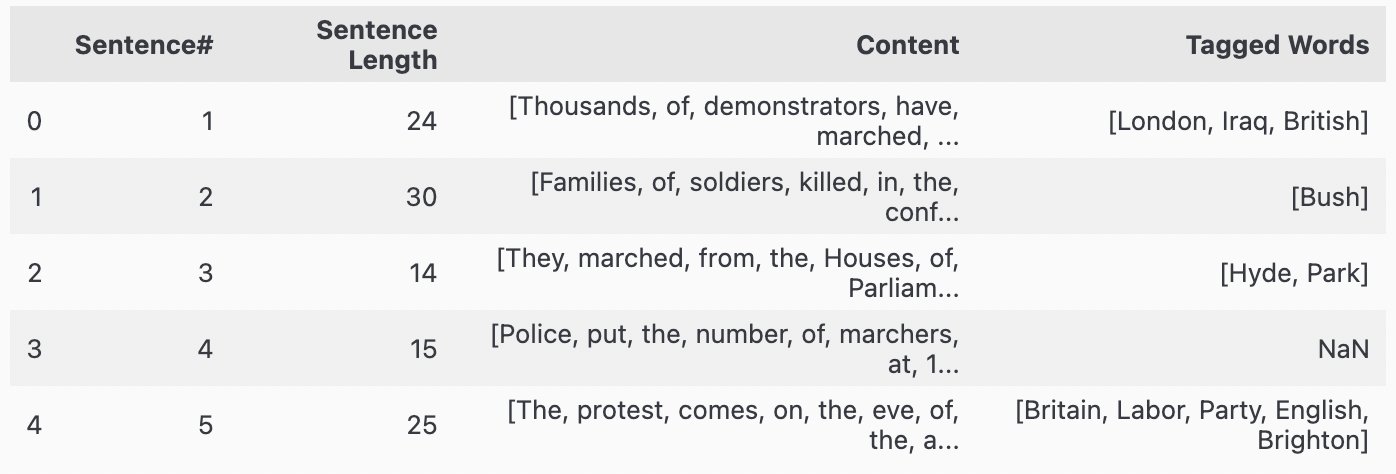

In [1]:
from IPython.display import Image, display
filename = '../doc_img/sentences_df.png'
display(Image(filename=filename))

### Plan
After finish feature engineering, we plan to use a pretrained `word2vec` model from `gensim`, which is trained on the entire Google News dataset, of about 100 billion words. Considering our data set is also from news article, this should be a good start point. Then we can feed the vectorized data to a clustering algorithm. 


### Load the data 

In [2]:
import pandas as pd 
import numpy as np

sentences_df = pd.read_csv('../datasets/sentences.csv')
extended_df = pd.read_csv('../datasets/extended_df.csv')

`sentences_df`

In [3]:
sentences_df.head()

,Unnamed: 0,Sentence Length,Sentence#
0,0,24,1
1,1,30,2
2,2,14,3
3,3,15,4
4,4,25,5


In [4]:
# drop column "Unnamed", reorder the remaining columns
cols = ['Sentence#', 'Sentence Length']
sentences_df = sentences_df.drop(columns=["Unnamed: 0"])
sentences_df = sentences_df[cols]

In [5]:
sentences_df.head()

,Sentence#,Sentence Length
0,1,24
1,2,30
2,3,14
3,4,15
4,5,25


Extract `reduced_df` from `extended_df`

In [6]:
extended_df.head()

,Unnamed: 0,Sentence #,Word,POS,Tag,WordLength,Capital,Non-Punctuation,StopWord,IsNER
0,0,Sentence: 1,Thousands,NNS,O,9,True,True,False,0
1,1,NaN,of,IN,O,2,False,True,True,0
2,2,NaN,demonstrators,NNS,O,13,False,True,False,0
3,3,NaN,have,VBP,O,4,False,True,True,0
4,4,NaN,marched,VBN,O,7,False,True,False,0


In [7]:
reduced_df = extended_df[['Sentence #', 'Word', 'Tag']].copy()

In [8]:
reduced_df.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


### Prepare `reduced_df` for feature extraction of `sentences_df`

In [9]:
reduced_df.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


1. In `Sentence #` column, we replace `NaN` by the sentence number the word belongs to. 

In [10]:
sentence_nums = reduced_df['Sentence #'].copy()
sentence_nums = sentence_nums.apply(lambda x: 0 if pd.isna(x) else 1)
sentence_nums = sentence_nums.cumsum()
reduced_df['Sentence num'] = sentence_nums
reduced_df = reduced_df.drop(columns=['Sentence #'])

In [11]:
reduced_df.iloc[22: 26]

,Word,Tag,Sentence num
22,country,O,1
23,.,O,1
24,Families,O,2
25,of,O,2


2. Change values in `Word` column from `str` to `[str]`. 

In [12]:
word_col = reduced_df.copy()['Word'].apply(lambda x: [x])  # pd.Series

In [13]:
reduced_df = reduced_df.assign(Word=word_col)

In [14]:
reduced_df

,Word,Tag,Sentence num
0,[Thousands],O,1
1,[of],O,1
2,[demonstrators],O,1
3,[have],O,1
4,[marched],O,1
...,...,...,...
1048570,[they],O,47959
1048571,[responded],O,47959
1048572,[to],O,47959
1048573,[the],O,47959


###  Add `Content` column to `setentences_df`

In [15]:
df_grouped_temp = reduced_df.copy().groupby(['Sentence num']).sum()

In [16]:
df_grouped_temp.head(2)

,Word,Tag
Sentence num,,
1,"[Thousands, of, demonstrators, have, marched, ...",OOOOOOB-geoOOOOOB-geoOOOOOB-gpeOOOOO
2,"[Families, of, soldiers, killed, in, the, conf...",OOOOOOOOOOOOOOOOOOB-perOOOOOOOOOOO


In [17]:
df_grouped_temp = df_grouped_temp.reset_index()

In [18]:
df_grouped_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47959 entries, 0 to 47958
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sentence num  47959 non-null  int64 
 1   Word          47959 non-null  object
 2   Tag           47959 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [19]:
content = df_grouped_temp.copy()['Word']
sentences_df = sentences_df.assign(Content=content)

In [20]:
sentences_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47959 entries, 0 to 47958
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentence#        47959 non-null  int64 
 1   Sentence Length  47959 non-null  int64 
 2   Content          47959 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### Add `Tagged Words` to `sentences_df`

In [21]:
reduced_df['Tagged Word'] = reduced_df.loc[:, 'Word'] # create a column 'Tagged word'
reduced_df.loc[reduced_df['Tag']=='O', 'Tagged Word'] = np.nan

In [22]:
reduced_df.head(10)

,Word,Tag,Sentence num,Tagged Word
0,[Thousands],O,1,NaN
1,[of],O,1,NaN
2,[demonstrators],O,1,NaN
3,[have],O,1,NaN
4,[marched],O,1,NaN
5,[through],O,1,NaN
6,[London],B-geo,1,[London]
7,[to],O,1,NaN
8,[protest],O,1,NaN
9,[the],O,1,NaN


In [23]:
df_grouped_temp = reduced_df.copy().groupby("Sentence num").sum()
df_grouped_temp = df_grouped_temp.reset_index()

In [24]:
sentences_df['Tagged Words'] = df_grouped_temp['Tagged Word']
sentences_df.loc[sentences_df["Tagged Words"]==0, 'Tagged Words'] = np.nan

In [25]:
sentences_df.head()

,Sentence#,Sentence Length,Content,Tagged Words
0,1,24,"[Thousands, of, demonstrators, have, marched, ...","[London, Iraq, British]"
1,2,30,"[Families, of, soldiers, killed, in, the, conf...",[Bush]
2,3,14,"[They, marched, from, the, Houses, of, Parliam...","[Hyde, Park]"
3,4,15,"[Police, put, the, number, of, marchers, at, 1...",NaN
4,5,25,"[The, protest, comes, on, the, eve, of, the, a...","[Britain, Labor, Party, English, Brighton]"


### Save `reduced_df` and `sentences_df` as csv files

In [26]:
reduced_df.to_csv('reduced_df.csv')
sentences_df.to_csv('sentences_df.csv')

### Word embedding  

We load a pretrained word2vec model from `gensim`, which is trained on the entire Google News dataset, of about 100 billion words. 

- Note that, the texts from our dataset are also from news. 
- We will train our own model if needed later. 

In [27]:
## Download the full model 
# import gensim.downloader as api 
# wv = api.load('word2vec-google-news-300')

### Feed to a clustering model 